# Multi Label Classification

In [1]:
import scipy.io as sio
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing
import sys
import datetime
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


In [2]:
# load a .mat file into a numpy array
def load_mat(filename):
    data = sio.loadmat(filename)
    # return data['data']
    return data

In [3]:
# Step 1: load the embeddings from word_2_vec format using keyedvectors
model = KeyedVectors.load_word2vec_format('blogcatalog.txt', binary=False)
print(model)

INFO - 2023-11-28 00:07:46,468: loading projection weights from blogcatalog.txt
INFO - 2023-11-28 00:07:47,068: KeyedVectors lifecycle event {'msg': 'loaded (10312, 128) matrix of type float32 from blogcatalog.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-11-28T00:07:47.068100', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'load_word2vec_format'}


KeyedVectors<vector_size=128, 10312 keys>


In [6]:
# Step 2: Also obtain the labels
data_np = load_mat('blogcatalog.mat')
labels_one_hot = data_np['group'].toarray()

print(labels_one_hot.shape)     # (10312, 39)

'''Now we know that the labels are one-hot encoded'''
label_sample = labels_one_hot[123]      # Thus, each node can have multiple labels (indicated by 2 ones in the array)
print(label_sample)

(10312, 39)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# Iterate over the keyed vectors to get the embeddings
embeddings = []
for node in range(10312):
    embeddings.append(np.array(model[node]))
embeddings = np.array(embeddings)

In [34]:
subgraph_size = 50

# Sample 500 random nodes from the network
random_nodes = np.random.choice(10312, subgraph_size, replace=False)

# Now, find the pairwise hamming distance between the labels of these nodes
# And visualize that graph
hamming_distance = []

for i in range(subgraph_size):
        for j in range(subgraph_size):
                hamming_distance.append(np.sum(np.logical_xor(labels_one_hot[random_nodes[i]], labels_one_hot[random_nodes[j]])))

hamming_distance = np.array(hamming_distance)

# Plot the subgraph with the edge opacity inversely proportional to the hamming distance
G = nx.Graph()
for i in range(subgraph_size):
        for j in range(subgraph_size):
                if i != j:
                        G.add_edge(i, j, weight=39 - hamming_distance[i*subgraph_size + j])

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


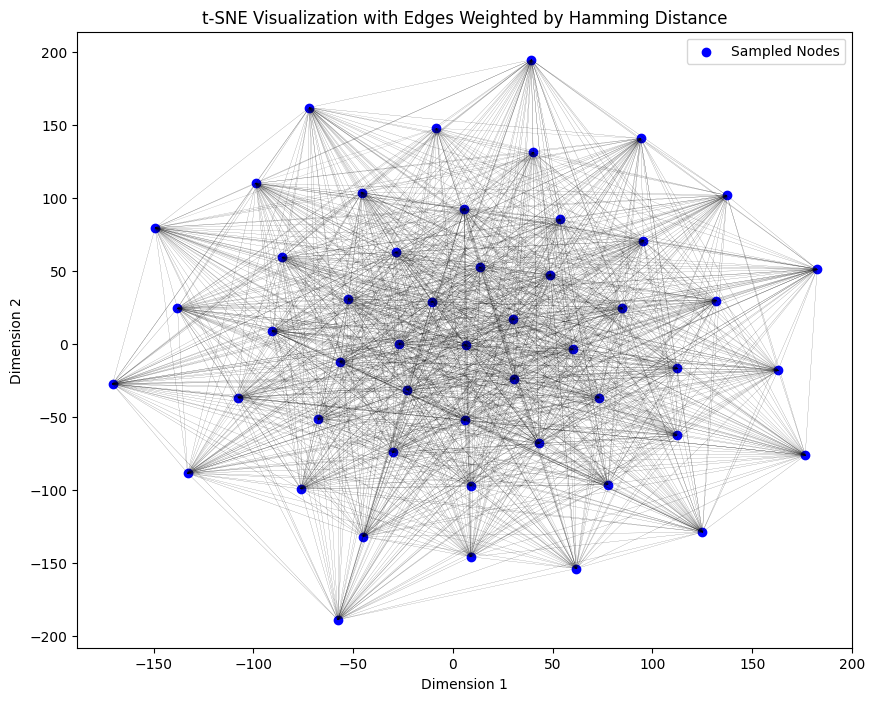

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'embeddings' is your array of node embeddings
# Assuming 'random_nodes' is your array of sampled node indices

# Extract the embeddings of the sampled nodes
sampled_embeddings = embeddings[random_nodes]

# Dimensionality reduction to 2 dimensions using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sampled_embeddings)

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='b', marker='o', label='Sampled Nodes')

# Draw lines between every pair of nodes with opacity based on the weight
for i in range(len(random_nodes)):
    for j in range(len(random_nodes)):
        if i != j:
            weight = 39 - hamming_distance[i * subgraph_size + j]
            plt.plot([embeddings_2d[i, 0], embeddings_2d[j, 0]],
                     [embeddings_2d[i, 1], embeddings_2d[j, 1]],
                     color='black', alpha=weight / 40.0, linewidth = 0.1)

plt.title('t-SNE Visualization with Edges Weighted by Hamming Distance')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [12]:
# define the classification model: One vs rest classifier -> Obtained from ChatGPT
class TopKRanker(OneVsRestClassifier):
    def __init__(self, estimator=None):
        super(TopKRanker, self).__init__(estimator=estimator)

    def predict(self, X, top_k_list):
        assert X.shape[0] == len(top_k_list)
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = np.argsort(probs_)[-k:].tolist()  # Get indices of top k labels
            all_labels.append(labels)
        return all_labels


In [13]:
training_fraction = [0.1,0.2, 0.3, 0.4, 0.5,0.6, 0.7,0.8, 0.9]
dataset_size = labels_one_hot.shape[0]
embedding_dim = 128

micro_f1_scores = []
macro_f1_scores = []

# loop through the training fractions and see how micro and macro F1 scores change -> autocompleted by copilot
for fraction in training_fraction:
    # Step 3: Shuffle the dataset
    np.random.seed(0)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    # Step 4: Obtain the training and testing indices
    training_size = int(dataset_size * fraction)
    test_size = dataset_size - training_size
    training_indices = indices[:training_size]
    testing_indices = indices[training_size:]

    # Step 4.1: Initialize empty matrices for X_train and X_test
    X_train = np.zeros((training_size, embedding_dim))  # 'train_size' is the size of our training set
    X_test = np.zeros((test_size, embedding_dim))    # 'test_size' is the size of our test set

        # We need to populate 'train_indices' and 'test_indices' based on our train/test split

    # Populate X_train with embeddings for train set nodes
    for i, node_index in enumerate(training_indices):
        if str(node_index) in model:
            X_train[i] = model[str(node_index)]

    # Populate X_test with embeddings for test set nodes
    for i, node_index in enumerate(testing_indices):
        if str(node_index) in model:
            X_test[i] = model[str(node_index)]

    # Step 4.2: Obtain the training and testing labels
    y_train = labels_one_hot[training_indices]
    y_test = labels_one_hot[testing_indices]

    print("sample y_train:",y_train[0])
    # Step 5: Change the labels to a list of labels for OnevsRestClassifier
    train_labels = []
    test_labels = []
    for i in range(y_train.shape[0]):
        train_labels.append(np.where(y_train[i] == 1)[0].tolist())
    for i in range(y_test.shape[0]):
        test_labels.append(np.where(y_test[i] == 1)[0].tolist())

    # Step 6: Train the classifier
    classifier = TopKRanker(LogisticRegression())
    # classifier.fit(X_train, train_labels)
    classifier.fit(X_train, y_train)

    # Step 7: Obtain the predictions
    predictions = classifier.predict(X_test, top_k_list=[len(l) for l in test_labels])

    # Step 8: Calculate the micro and macro F1 scores
    mlb = MultiLabelBinarizer(classes=np.arange(40))
    binary_predictions = mlb.fit_transform(predictions)
    micro_f1 = f1_score(y_test, binary_predictions, average='micro')
    macro_f1 = f1_score(y_test, binary_predictions, average='macro')

    micro_f1_scores.append(micro_f1)
    macro_f1_scores.append(macro_f1)

    print("Training fraction: ", fraction)
    print("Micro F1 score: ", micro_f1)
    print("Macro F1 score: ", macro_f1)
    print("-------------------------------------------------")
    

/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 20 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 21 is present in all training examples.
  warnings.warn(
/hom

sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training fraction:  0.1
Micro F1 score:  0.3351422463410623
Macro F1 score:  0.05503158780556748
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 21 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 27 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 31 is present in all training examples.
  warnings.warn(
/hom

Training fraction:  0.2
Micro F1 score:  0.34532640949554894
Macro F1 score:  0.05424261558167613
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 21 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 27 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 31 is present in all training examples.
  warnings.warn(
/hom

Training fraction:  0.3
Micro F1 score:  0.3739406779661017
Macro F1 score:  0.05964368484981912
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 21 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 39 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 i

Training fraction:  0.4
Micro F1 score:  0.37820512820512825
Macro F1 score:  0.061843092856722306
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 13 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 39 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true

Training fraction:  0.5
Micro F1 score:  0.39435364041604754
Macro F1 score:  0.06469419104536109
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 39 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Training fraction:  0.6
Micro F1 score:  0.39482439926062846
Macro F1 score:  0.06601225026141307
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Training fraction:  0.7
Micro F1 score:  0.39538310412573674
Macro F1 score:  0.06498354649851722
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Training fraction:  0.8
Micro F1 score:  0.39883551673944684
Macro F1 score:  0.060720472132939685
-------------------------------------------------
sample y_train: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training fraction:  0.9
Micro F1 score:  0.3922734026745914
Macro F1 score:  0.05924564659505338
-------------------------------------------------


/home/anika/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Text(0, 0.5, 'F1 score')

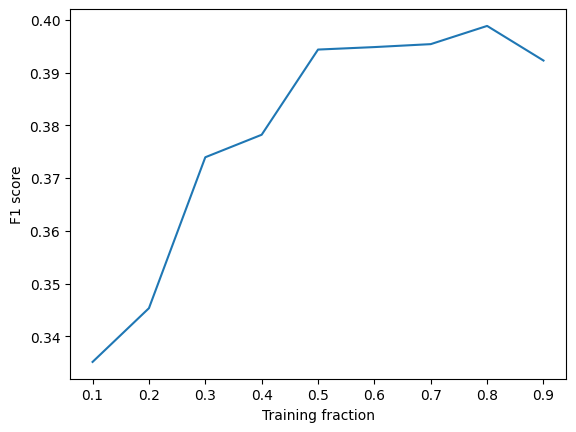

In [14]:
# plot the micro and macro f1 scores against training fraction
plt.plot(training_fraction, micro_f1_scores, label='micro f1')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')

Text(0, 0.5, 'F1 score')

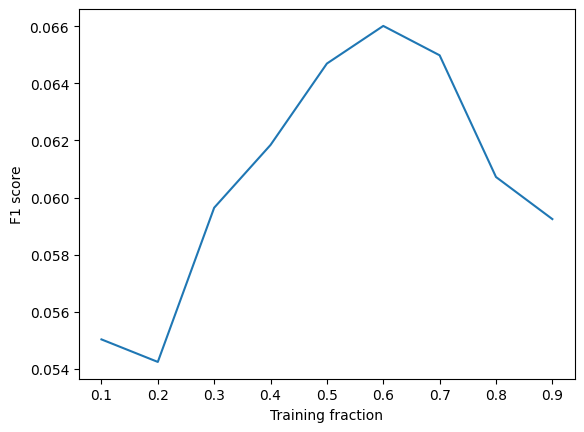

In [15]:
# plot the micro and macro f1 scores against training fraction
plt.plot(training_fraction, macro_f1_scores, label='macro f1')
plt.xlabel('Training fraction')
plt.ylabel('F1 score')